<a href="https://colab.research.google.com/github/D-Agar/imlo_courework/blob/master/Coursework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intelligent Systems - Individual Project Assessment
I aim to split the code into 3 sections:
1. Generating and analysing the datset
2. Developing my classification model
3. Training my model

In [9]:
import math
import time

import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from torchvision.transforms import v2
from torch.nn import functional as F
from scipy import io as sio

# torch.manual_seed(30)
# torch.cuda.empty_cache()

In [10]:
# set the selected device for the tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if (torch.cuda.is_available()):
  print(torch.cuda.get_device_name(device))
torch.set_default_device(device)

Using device: cuda
Tesla T4


## Dataset

### Data Augmentation
After inspection of the dataset, we have PIL images. Therefore, we will convert these to Tensors.

The values used for the normalisation of data were calculated from the ImageNet training datase

In [11]:
# We perform random transformations to better generalise the training dataset
train_transform = transforms.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(10),
    v2.ToDtype(torch.float32, scale=True),
    # These are the values I have calculated
    # v2.Normalize(mean=[0.433, 0.382, 0.296], std=[0.259, 0.209, 0.221])
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    v2.ToImage(),
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    # v2.Normalize(mean=[0.433, 0.382, 0.296], std=[0.259, 0.209, 0.221])
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    v2.ToImage(),
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    # v2.Normalize(mean=[0.433, 0.382, 0.296], std=[0.259, 0.209, 0.221])
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Downloading and splitting the dataset

In [12]:
# I will download the data from PyTorch's website and use the appropriate data loader
train_dataset = datasets.Flowers102(
    root='',
    split="train",
    download=True,
    transform=train_transform
    # target_transform=Lambda(lambda y: F.one_hot(torch.FloatTensor(y), num_classes=102))
)

valid_dataset = datasets.Flowers102(
    root='',
    split="val",
    download=True,
    transform=valid_transform,
    # target_transform=Lambda(lambda y: torch.zeros(102, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

test_dataset = datasets.Flowers102(
    root='',
    split="test",
    download=True,
    transform=test_transform
)

# Get the targets and ids
image_labels = sio.loadmat("flowers-102/imagelabels")
setids = sio.loadmat("flowers-102/setid")
image_labels

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009',
 '__version__': '1.0',
 '__globals__': [],
 'labels': array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)}

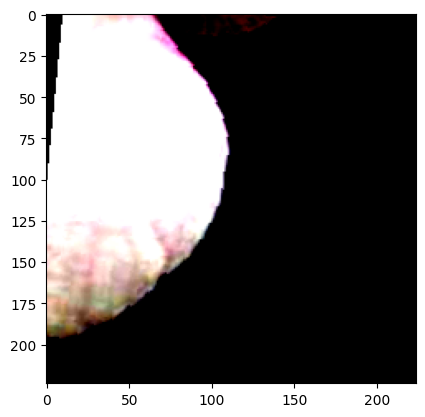

In [13]:
image, label = train_dataset[12]
plt.imshow(image.cpu().permute(1,2,0))

Image shape: torch.Size([3, 224, 224]) -> [batch, height, width]
Datatype: torch.float32
Label: 0
Device tensor is stored on: cuda:0


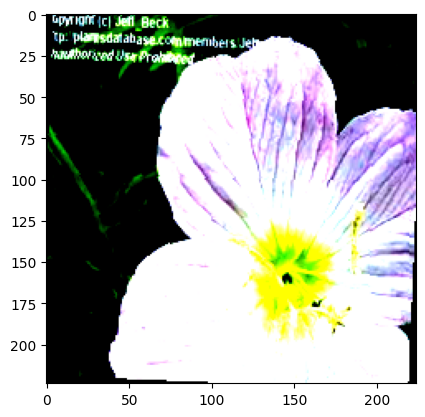

In [14]:
# look at the first training sample
image, label = train_dataset[1]
print(f"Image shape: {image.shape} -> [batch, height, width]")
print(f"Datatype: {image.dtype}")
print(f"Label: {label}")
print(f"Device tensor is stored on: {image.device}")
plt.imshow(image.cpu().permute(1, 2, 0))

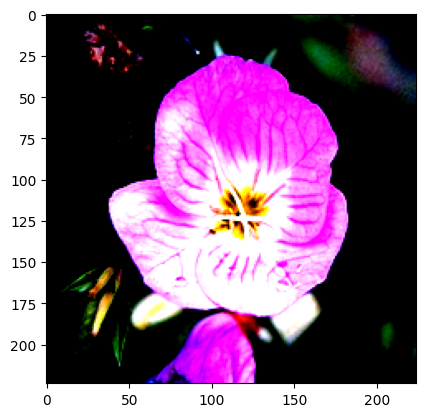

In [15]:
image2, label = test_dataset[0]
plt.imshow(image2.cpu().permute(1, 2, 0))

## Model

### Model 1

In [16]:
class MyNN1(nn.Module):
    def __init__(self):
        super().__init__()
        # First, try to get the bigger picture (max pooling and larger filter)
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Gradually build up features
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # self.layer5 = nn.Sequential(
        #     nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        #     nn.LeakyReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        #     nn.BatchNorm2d(512)
        # )

        self.flatten = nn.Flatten()

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*14*14, 1024),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU()
        )
        self.fc3 = nn.Linear(512, 102)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # x = self.layer5(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

### Model 2

In [17]:
class MyNN2(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.flatten = nn.Flatten()

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU()
        )

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU()
        )

        self.fc2= nn.Sequential(
            nn.Linear(1024, 102))

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)

        x = self.flatten(x)
        x = self.fc(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

### Model 3
Here, I am going to try reduce the number of pooling layers, as information may be lost when using too many

In [18]:
class ResidualBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(planes),
        )
        self.relu = nn.ReLU()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.layer1(x)
        out = self.layer2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out

In [19]:
class MyNN3(nn.Module):
    def __init__(self):
        super().__init__()

        self.inplanes = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.inplanes),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.layer1 = self.layer(ResidualBlock, 64, 3)
        self.layer2 = self.layer(ResidualBlock, 128, 4, stride=2)
        self.layer3 = self.layer(ResidualBlock, 256, 6, stride=2)
        self.layer4 = self.layer(ResidualBlock, 512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, 102)

    def layer(self, block, planes, blocks, stride=1):
        downsample = None

        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))

        self.inplanes = planes

        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)

        return x

### Model 4
I have now added dropout to the model

In [20]:
class ResidualBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(planes),
        )
        self.relu = nn.ReLU()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.layer1(x)
        out = self.layer2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out

In [21]:
class MyNN4(nn.Module):
    def __init__(self):
        super().__init__()

        self.inplanes = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.inplanes),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.layer1 = self.layer(ResidualBlock, 64, 3)
        self.layer2 = self.layer(ResidualBlock, 128, 4, stride=2)
        self.layer3 = self.layer(ResidualBlock, 256, 6, stride=2)
        self.layer4 = self.layer(ResidualBlock, 512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 102)

    def layer(self, block, planes, blocks, stride=1):
        downsample = None

        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))

        self.inplanes = planes

        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)

        return x

### Model 5

In [22]:
class MyNN5(nn.Module):
    def __init__(self, num_classes=102):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 14 * 14, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return nn.Softmax2d(x)

### Choosing the Model

In [23]:
model = MyNN1()
model.to(device)

MyNN1(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, k

## Training

### Loss Function

In [24]:
# Targets don't have to be one-hot encoded
# Model output (criterion input) is expected to contain un-normalised inputs
criterion = nn.CrossEntropyLoss()

### Optimiser

In [36]:
# Momentum pushes the optimiser towards the strongest gradient over multiple steps.
# optimiser = optim.SGD(model.parameters(), lr=0.005, weight_decay=0.005, momentum=0.9)
optimiser = optim.Adam(model.parameters(), lr=0.001)

### Dataloaders

In [37]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0, generator=torch.Generator(device=device))

# Use CutMix and MixUp to reduce overfitting and improve the overall classification accuracy
cutmix = v2.CutMix(num_classes=102)
mixup = v2.MixUp(num_classes=102)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

In [38]:
valid_loader = DataLoader(valid_dataset, batch_size, num_workers=0, generator=torch.Generator(device=device))

### Full training of model

In [39]:
def train_model(model, criterion, optimizer, train_loader, valid_loader, path, num_epochs=10):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = cutmix_or_mixup(inputs, labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predictions = outputs.argmax(dim=1)
            y = labels.argmax(dim=1)
            train_corrects += (predictions == y).sum().item()

        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)
        train_acc = train_corrects / len(train_loader.dataset)
        train_accuracies.append(train_acc)

        # Set the model to evaluation mode
        model.eval()
        valid_loss = 0.0
        valid_corrects = 0

        with torch.no_grad():
            # Validation phase
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                valid_loss += loss.item()
                valid_corrects += (outputs.argmax(dim=1) == labels).sum().item()

        valid_loss = valid_loss / len(valid_loader)
        valid_acc = valid_corrects / len(valid_loader.dataset)
        val_accuracies.append(valid_acc)
        val_losses.append(valid_loss)

        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), path)


        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Training: Avg loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}%, '
              f'Validation: Avg loss: {valid_loss:.4f}, Accuracy: {valid_acc*100:.2f}%')
    return train_losses, train_accuracies, val_losses, val_accuracies

In [40]:
epochs = 100
PATH = 'model1.pth'

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, criterion, optimiser, train_loader, valid_loader, PATH, epochs)

Epoch 1/100: Training: Avg loss: 3.6357, Accuracy: 26.37%, Validation: Avg loss: 4.2153, Accuracy: 12.45%
Epoch 2/100: Training: Avg loss: 3.8066, Accuracy: 20.59%, Validation: Avg loss: 3.6196, Accuracy: 17.75%
Epoch 3/100: Training: Avg loss: 3.7736, Accuracy: 21.37%, Validation: Avg loss: 3.5044, Accuracy: 20.10%
Epoch 4/100: Training: Avg loss: 3.7140, Accuracy: 23.63%, Validation: Avg loss: 3.1784, Accuracy: 27.25%
Epoch 5/100: Training: Avg loss: 3.7361, Accuracy: 21.57%, Validation: Avg loss: 3.2280, Accuracy: 25.10%
Epoch 6/100: Training: Avg loss: 3.5221, Accuracy: 25.59%, Validation: Avg loss: 3.1238, Accuracy: 27.06%
Epoch 7/100: Training: Avg loss: 3.4929, Accuracy: 25.00%, Validation: Avg loss: 3.1306, Accuracy: 26.18%
Epoch 8/100: Training: Avg loss: 3.5259, Accuracy: 26.27%, Validation: Avg loss: 3.1228, Accuracy: 27.94%
Epoch 9/100: Training: Avg loss: 3.5854, Accuracy: 25.59%, Validation: Avg loss: 3.3400, Accuracy: 23.73%
Epoch 10/100: Training: Avg loss: 3.2136, Accu

KeyboardInterrupt: 

### Visualisation

In [ ]:
# Visualise the losses
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Visualise the accuracy
plt.plot(train_accuracies, label='Training')
plt.plot(val_accuracies, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Testing

In [ ]:
# Test on test dataset
test_loader = DataLoader(test_dataset, batch_size, num_workers=0, generator=torch.Generator(device=device))

In [ ]:
def test(model, test_loader):
    model.eval()
    with torch.no_grad():
        acc = .0
        for i, data in enumerate(test_loader):
            X = data[0].to(device)
            y = data[1].to(device)

            predicted = model(X)

            # Check each image's prediction
            acc += (predicted.argmax(dim=1) == y).sum().item()
    model.train()
    return acc/len(test_loader.dataset)

In [ ]:
test_model = MyNN1().to(device)
test_model.load_state_dict(torch.load(PATH))
test_acc = test(test_model, test_loader)

In [ ]:
print(f"Test Accuracy: {test_acc*100:.2f}%")